In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from pandas.plotting import scatter_matrix
from sklearn.metrics import r2_score, classification_report
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import ipywidgets as widgets
from IPython.display import display, clear_output
from pandas.io.formats import style
from IPython.display import display
from ipywidgets import Button, GridBox, Layout, ButtonStyle


%matplotlib inline

initial_df = pd.read_csv("insurance.csv")

# one hot encoding
df = pd.get_dummies(initial_df, drop_first=True)
# dodanie kategorii otyły (w USA wg jakiegoś medycznego instytu jest po prostu powyżej 30
df["obese"] = df["bmi"].apply(lambda x: 1 if x >= 30 else 0)
# dodanie kategorii otyły i palący
df["obese_smoker"] = df[["obese", "smoker_yes"]].apply(
    lambda x: 1 if (x["obese"] == 1) & (x["smoker_yes"] == 1) else 0, axis=1
)

In [114]:
#centrowanie wykresów w Jupyter output

from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)
from IPython.display import display, HTML

CSS = """
.output {
    align-items: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [115]:
initial_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [116]:
df.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest', 'obese',
       'obese_smoker'],
      dtype='object')

# <center> JAK KOSZTOWNE JEST ZDROWIE?  </center>

a. określane kosztów zdrowia na podstawie parametrów ubezpieczonego

b. aplikacja pomagająca wyznaczyć progi ubezpieczenia 

https://www.kaggle.com/mirichoi0218/insurance 

In [117]:
# sprawdzenie liczby rekordów
n_records = df.shape[0]
columns = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

print('Liczba rekordow w bazie danych: {}'.format(n_records))
print('\nWyróżniki dostępne w bazie danych: ')
for col_name in columns: 
    print(col_name)

Liczba rekordow w bazie danych: 1338

Wyróżniki dostępne w bazie danych: 
age
sex
bmi
children
smoker
region
charges


<h1><center>Analiza danych</center></h1>


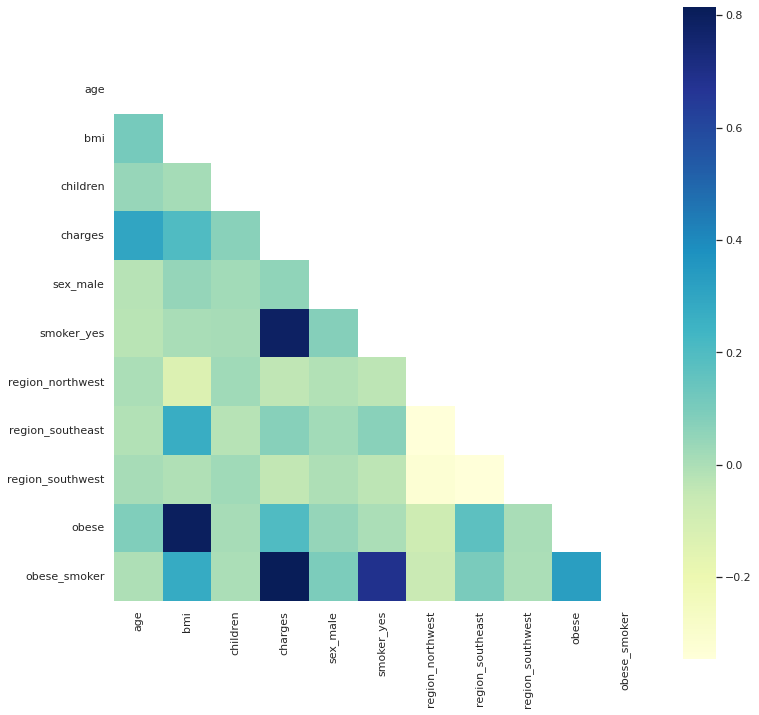

In [118]:
# nowa mapa korelacji
corr = np.corrcoef(np.random.randn(11, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12, 12))
_=sns.heatmap(df.corr(), cmap="YlGnBu", mask=mask, square=True)

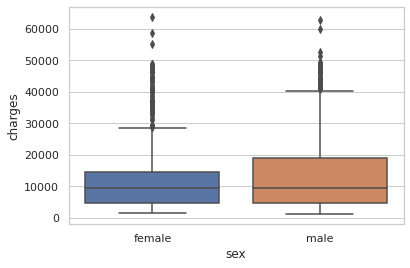

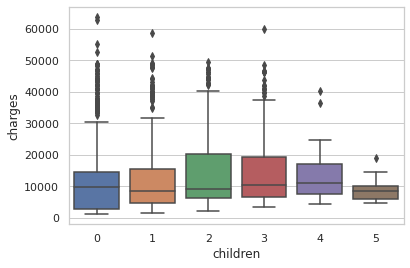

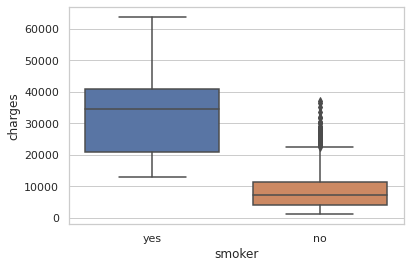

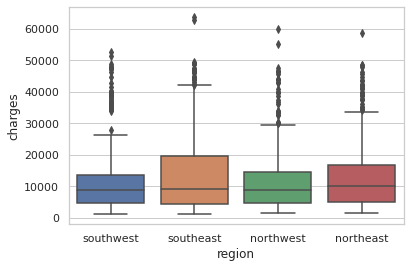

In [72]:
var_list = ['age','sex', 'bmi','children', 'smoker', 'region', 'charges']

for column in initial_df.columns:
    sns.set_theme(style="whitegrid")
    if column in ['sex','smoker','region', 'children']:
        sns.boxplot(x=initial_df[column], y=df["charges"])
        plt.show()

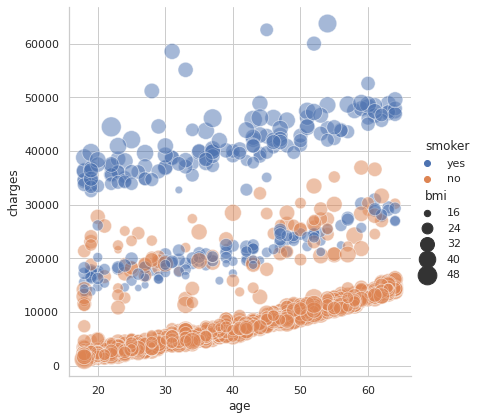

In [73]:
_=sns.relplot(x="age", y="charges", hue="smoker", size="bmi",
            sizes=(40, 400), alpha=.5, 
            height=6, data=initial_df)

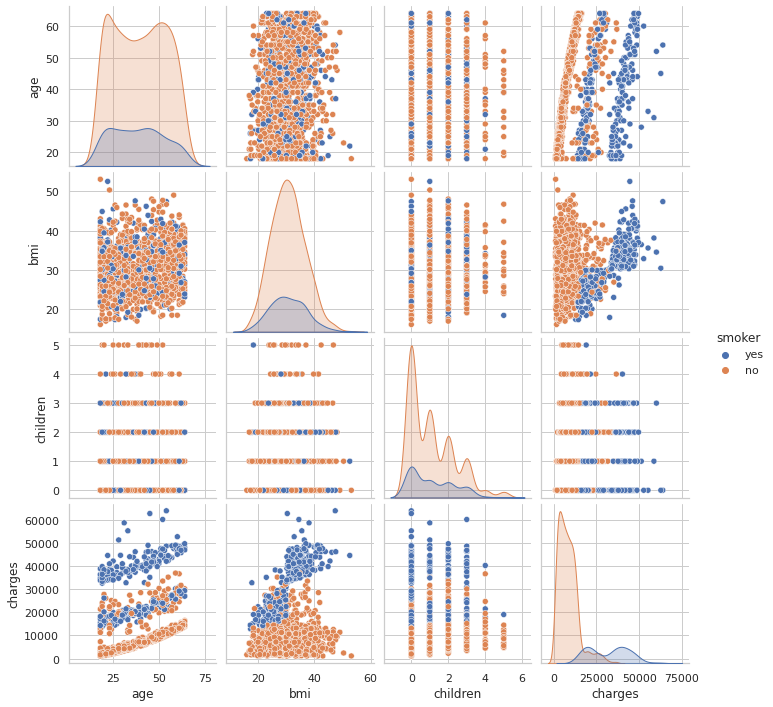

In [74]:
sns.pairplot(initial_df, hue='smoker')
plt.show()

KeyError: 'charges_thresholds'

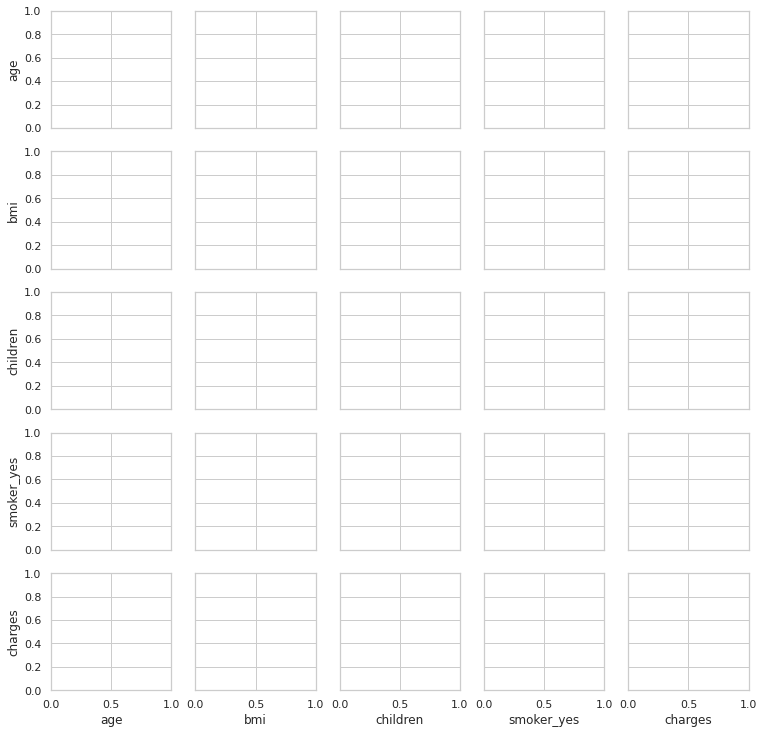

In [103]:
sns.pairplot(df, vars=['age','bmi','children','smoker_yes', 'charges'], hue='charges_thresholds')
plt.show()

In [127]:
import pickle
# Load the Model back from file
Pkl_Ridge = 'pickled_ridge_model.pkl'  
Pkl_EN = 'pickled_en_model.pkl'  
Pkl_XGB = 'pickled_xgb_model.pkl'  
Pkl_Stacked = 'pickled_stacked_model.pkl'
Pkl_data='pickled_data'


with open(Pkl_Ridge, 'rb') as file1:  
    ridge_model = pickle.load(file1)

with open(Pkl_EN, 'rb') as file2:  
    en_model = pickle.load(file2)
    
with open(Pkl_XGB, 'rb') as file3:  
    xgb_model = pickle.load(file3)

with open(Pkl_Stacked, 'rb') as file4:  
    stacked_model = pickle.load(file4)
    
with open(Pkl_data, 'rb') as file4:  
    df = pickle.load(file4)


In [128]:
from sklearn.model_selection import train_test_split

X = df.drop('charges', axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,obese,obese_smoker
0,19,27.90,0,0,1,0,0,1,0,0
1,18,33.77,1,1,0,0,1,0,1,0
2,28,33.00,3,1,0,0,1,0,1,0
3,33,22.70,0,1,0,1,0,0,0,0
4,32,28.88,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,30.97,3,1,0,1,0,0,1,0
1334,18,31.92,0,0,0,0,0,0,1,0
1335,18,36.85,0,0,0,0,1,0,1,0
1336,21,25.80,0,0,0,0,0,1,0,0


In [129]:
ridge_model.score(X_test,y_test)

0.8712125654141842

In [130]:
en_model.score(X_test,y_test)

0.8711719305610985

In [131]:
xgb_model.score(X_test,y_test)

0.8730627049627262

In [132]:
# bardziej powtarzalny, lepszy wynik z CV
stacked_model.score(X_test,y_test)

0.8728794330786501

In [133]:
en_model.predict(X_train)

array([13913.64195573,  8829.70456694, 13185.04512187, 45486.8907723 ,
       39309.35166281, 43184.34438114,  6788.31663564,  5238.60045379,
       14388.70942618,  9098.42939517, 43581.93851328,  3132.92222867,
        8818.53356615, 12306.81735487, 21402.07861398,  5324.71996996,
        4235.52560878, 13853.06951407,  5295.56958126,  5801.90713228,
        9114.06570148,   956.66372037, 20969.55010816, 10438.62732921,
        7793.11413168,  4988.06961942,  6679.69285469, 13480.21476756,
       19188.72568481, 10468.5391609 ,  9146.37114738,  6331.9480034 ,
        7929.1897942 ,  2881.52100456,  7860.74567204,  9750.7286233 ,
       11635.24311388, 10510.03065924,  7414.31506644,  3205.48545008,
        9508.61249847, 41363.70142044, 43334.48807913,  2012.23576324,
       46444.18791274, 35933.87533802, 12009.75892844,  1874.39217718,
       14303.99937297,  1737.38843694,  9782.9640594 , 38022.57037953,
       15351.1705075 , 12024.31577246,  8876.77254835, 13364.17853408,
      

In [83]:
predykcja = en_model.predict(pd.DataFrame([[47,29.5, 0, 0, 0, 1, 0, 0, 0, 0]], columns=['age', 'bmi', 'children', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest', 'obese', 'obese_smoker']))
predykcja

array([10664.90195364])

In [84]:
({'age':20,'bmi':25, 'children':3,'sex_male':0,'smoker_yes':1,
                  'region_northwest':1,'region_southeast':0,'region_southwest':0,'obese':1,'obese_smoker':1})

{'age': 20,
 'bmi': 25,
 'children': 3,
 'sex_male': 0,
 'smoker_yes': 1,
 'region_northwest': 1,
 'region_southeast': 0,
 'region_southwest': 0,
 'obese': 1,
 'obese_smoker': 1}

#### Ewaluacja modeli

In [121]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from math import sqrt

In [122]:
from sklearn import set_config
import time

In [123]:
def run_model(pipeline, Xtrain, ytrain, Xtest, ytest):
    set_config(display='diagram')
    pd.options.display.float_format = "{:,.2f}".format
    
    pipeline_name = display(pipeline)
    
    fit_start_time = time.time()
    pipeline.fit(Xtrain, ytrain)
    fit_end_time = time.time()
    
    y_pred_train = pipeline.predict(Xtrain).reshape(-1,1)
    pred_start_time = time.time()
    y_pred_test = pipeline.predict(Xtest).reshape(-1,1)
    pred_end_time = time.time()
    
    wyniki = {}
    wyniki['score'] = ['R^2', 'MSE', 'RMSE', 'MAE']
    wyniki['train_set'] = []
    wyniki['test_set'] = []
    
    r2_train_set = pipeline.score(Xtrain, ytrain) * 100
    MSE_train_set = mean_squared_error(ytrain, y_pred_train)
    RMSE_train_set = sqrt(mean_squared_error(ytrain, y_pred_train))
    MAE_train_set = mean_absolute_error(ytrain, y_pred_train)
    
    wyniki['train_set'].append(r2_train_set)
    wyniki['train_set'].append(MSE_train_set)
    wyniki['train_set'].append(RMSE_train_set)
    wyniki['train_set'].append(MAE_train_set)
    
    r2_test_set = pipeline.score(Xtest, ytest) * 100
    MSE_test_set = mean_squared_error(ytest, y_pred_test)
    RMSE_test_set = sqrt(mean_squared_error(ytest, y_pred_test))
    MAE_test_set = mean_absolute_error(ytest, y_pred_test)
    
    wyniki['test_set'].append(r2_test_set)
    wyniki['test_set'].append(MSE_test_set)
    wyniki['test_set'].append(RMSE_test_set)
    wyniki['test_set'].append(MAE_test_set)    
    
    cross_val = cross_val_score(pipeline, Xtrain, ytrain, cv=5).mean()
    
    df_wyniki = pd.DataFrame(wyniki)

    display(df_wyniki)
    print('\nCross validation score: {0:.2f}%'.format(100 * cross_val))
    print('Fit time elapsed: {0:.3f} sec'.format(fit_end_time - fit_start_time))
    print('Prediction time elapsed: {0:.3f} sec'.format(pred_end_time - pred_start_time))
    
    x_ax = range(len(y_test))
    plt.scatter(x_ax, ytest, label='original')
    plt.scatter(x_ax, y_pred_test, label='predicted')
    plt.title('Test and predicted data')
    plt.legend()
    plt.show()
    
    return pipeline.fit(Xtrain, ytrain)

In [88]:
models = [ridge_model, en_model]
models2= [xgb_model, stacked_model]

Ridge()

,score,train_set,test_set
0,R^2,86.04,87.12
1,MSE,"20,443,271.72","18,883,368.46"
2,RMSE,"4,521.42","4,345.50"
3,MAE,"2,539.09","2,424.17"



Cross validation score: 85.17%
Fit time elapsed: 0.003 sec
Prediction time elapsed: 0.001 sec


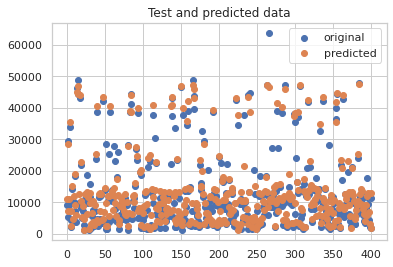

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet(alpha=0.01))])

,score,train_set,test_set
0,R^2,86.05,87.12
1,MSE,"20,438,964.80","18,889,326.52"
2,RMSE,"4,520.95","4,346.19"
3,MAE,"2,538.58","2,424.30"



Cross validation score: 85.17%
Fit time elapsed: 0.004 sec
Prediction time elapsed: 0.001 sec


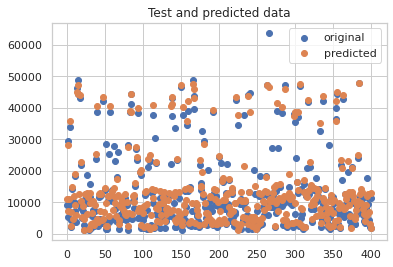

In [89]:
for model in models:
    run_model(model, X_train, y_train, X_test, y_test)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('xgbregressor',
                 XGBRegressor(alpha=0, base_score=0.5, booster='gblinear',
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, enable_categorical=False,
                              feature_selector='greedy', gamma=None, gpu_id=-1,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.09,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=16, num_parallel_tree=None, predictor=None,
                              random_state=0, reg_alpha=0, reg_lambda=0.001,
                              scale_pos_weight=1, subsample=None, top_k=7,
                              tree_method=None, updater='coord_descent', ...))])

,score,train_set,test_set
0,R^2,86.72,87.31
1,MSE,"19,456,763.67","18,612,093.03"
2,RMSE,"4,410.98","4,314.17"
3,MAE,"2,433.66","2,375.30"



Cross validation score: 85.22%
Fit time elapsed: 0.105 sec
Prediction time elapsed: 0.002 sec


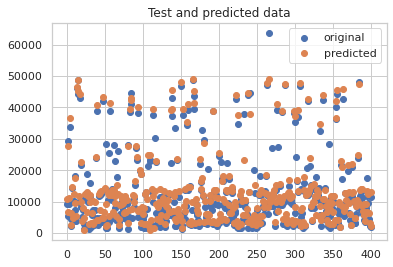

StackingRegressor(estimators=[('en',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('elasticnet',
                                                ElasticNet(alpha=0.01))])),
                              ('ridge', Ridge()),
                              ('xgb',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('polynomialfeatures',
                                                PolynomialFeatures(interaction_only=True)),
                                               ('xgbregressor',
                                                XGBRegressor(alpha=0,
                                                             base_score=0.5,
                                                             booster='gblinear',
                                                             colsampl...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.09,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=16,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=0,
                                                             reg_alpha=0,
                                                             reg_lambda=0.001,
                                                             scale_pos_weight=1,
                                                             subsample=None,
                                                             top_k=7,
                                                             tree_method=None,
                                                             updater='coord_descent', ...))]))])

,score,train_set,test_set
0,R^2,86.53,87.29
1,MSE,"19,735,920.53","18,638,965.14"
2,RMSE,"4,442.51","4,317.29"
3,MAE,"2,453.28","2,382.37"



Cross validation score: 85.25%
Fit time elapsed: 0.397 sec
Prediction time elapsed: 0.010 sec


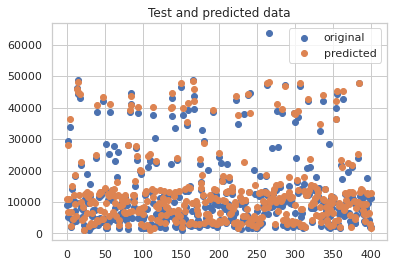

In [90]:
for model in models2:
    run_model(model, X_train, y_train, X_test, y_test)

Benchmarking Ridge()
Benchmarking Ridge()
Benchmarking Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('xgbregressor',
                 XGBRegressor(alpha=0, base_score=0.5, booster='gblinear',
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, enable_categorical=False,
                              feature_selector='greedy', gamma=None, gpu_id=-1,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.09,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=16, num_parallel_tree=None, predictor=None,
                          

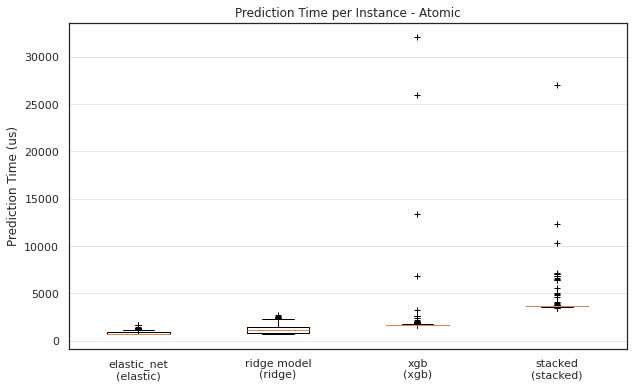

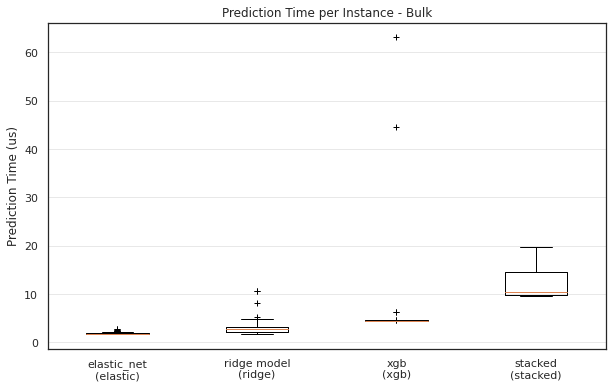

In [134]:
# Authors: Eustache Diemert <eustache@diemert.fr>
# License: BSD 3 clause

from collections import defaultdict

import time
import gc
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.utils import shuffle


def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return "__file__" in globals()


def atomic_benchmark_estimator(estimator, X_test=X_test, verbose=False):
    """Measure runtime prediction of each instance."""
    n_instances = X_test.shape[0]
    runtimes = np.zeros(n_instances, dtype=float)
    for i in range(n_instances):
        instance = X_test.iloc[[i], :]
        start = time.time()
        estimator.predict(instance)
        runtimes[i] = time.time() - start
    if verbose:
        print(
            "atomic_benchmark runtimes:",
            min(runtimes),
            np.percentile(runtimes, 50),
            max(runtimes),
        )
    return runtimes


def bulk_benchmark_estimator(estimator, n_bulk_repeats, X_test=X_test, verbose=False):
    """Measure runtime prediction of the whole input."""
    n_instances = X_test.shape[0]
    runtimes = np.zeros(n_bulk_repeats, dtype=float)
    for i in range(n_bulk_repeats):
        start = time.time()
        estimator.predict(X_test)
        runtimes[i] = time.time() - start
    runtimes = np.array(list(map(lambda x: x / float(n_instances), runtimes)))
    if verbose:
        print(
            "bulk_benchmark runtimes:",
            min(runtimes),
            np.percentile(runtimes, 50),
            max(runtimes),
        )
    return runtimes


def benchmark_estimator(estimator, X_test=X_test, n_bulk_repeats=50, verbose=False):
    """
    Measure runtimes of prediction in both atomic and bulk mode.

    Parameters
    ----------
    estimator : already trained estimator supporting `predict()`
    X_test : test input
    n_bulk_repeats : how many times to repeat when evaluating bulk mode

    Returns
    -------
    atomic_runtimes, bulk_runtimes : a pair of `np.array` which contain the
    runtimes in seconds.

    """
    atomic_runtimes = atomic_benchmark_estimator(estimator)
    bulk_runtimes = bulk_benchmark_estimator(estimator, n_bulk_repeats)
    return atomic_runtimes, bulk_runtimes



def boxplot_runtimes(runtimes, pred_type, configuration):
    """
    Plot a new `Figure` with boxplots of prediction runtimes.

    Parameters
    ----------
    runtimes : list of `np.array` of latencies in micro-seconds
    cls_names : list of estimator class names that generated the runtimes
    pred_type : 'bulk' or 'atomic'

    """

    fig, ax1 = plt.subplots(figsize=(10, 6))
    bp = plt.boxplot(
        runtimes,
    )

    cls_infos = [
        "%s\n(%s)"
        % (
            estimator_conf["name"],
            estimator_conf["complexity_label"],
        )
        for estimator_conf in configuration["estimators"]
    ]
    plt.setp(ax1, xticklabels=cls_infos)
    plt.setp(bp["boxes"], color="black")
    plt.setp(bp["whiskers"], color="black")
    plt.setp(bp["fliers"], color="red", marker="+")

    ax1.yaxis.grid(True, linestyle="-", which="major", color="lightgrey", alpha=0.5)

    ax1.set_axisbelow(True)
    ax1.set_title(
        "Prediction Time per Instance - %s"
        % (pred_type.capitalize())
    )
    ax1.set_ylabel("Prediction Time (us)")

    plt.show()


def benchmark(configuration):
    """Run the whole benchmark."""

    stats = {}
    for estimator_conf in configuration["estimators"]:
        print("Benchmarking", estimator_conf["instance"])
        estimator_conf["instance"].fit(X_train, y_train)
        gc.collect()
        a, b = benchmark_estimator(estimator_conf["instance"])
        stats[estimator_conf["name"]] = {"atomic": a, "bulk": b}
        
    cls_names = [
        estimator_conf["name"] for estimator_conf in configuration["estimators"]
    ]
    runtimes = [1e6 * stats[clf_name]["atomic"] for clf_name in cls_names]
    boxplot_runtimes(runtimes, "atomic", configuration)
    runtimes = [1e6 * stats[clf_name]["bulk"] for clf_name in cls_names]
    boxplot_runtimes(runtimes,"bulk", configuration)



# #############################################################################
# Main code

start_time = time.time()

# #############################################################################
# Benchmark bulk/atomic prediction speed for various regressors
configuration = {
    "estimators": [
        {
            "name": "elastic_net",
            "instance": ridge_model,
            "complexity_label": "elastic"
        },
        {
            "name": "ridge model",
            "instance": ridge_model,
            "complexity_label": "ridge"
        },
        {
            "name": "xgb",
            "instance": xgb_model,
            "complexity_label": "xgb"
        },
        {
            "name": "stacked",
            "instance": stacked_model,
            "complexity_label": "stacked"
        },
        
    ],
}
benchmark(configuration)


stop_time = time.time()

56
56


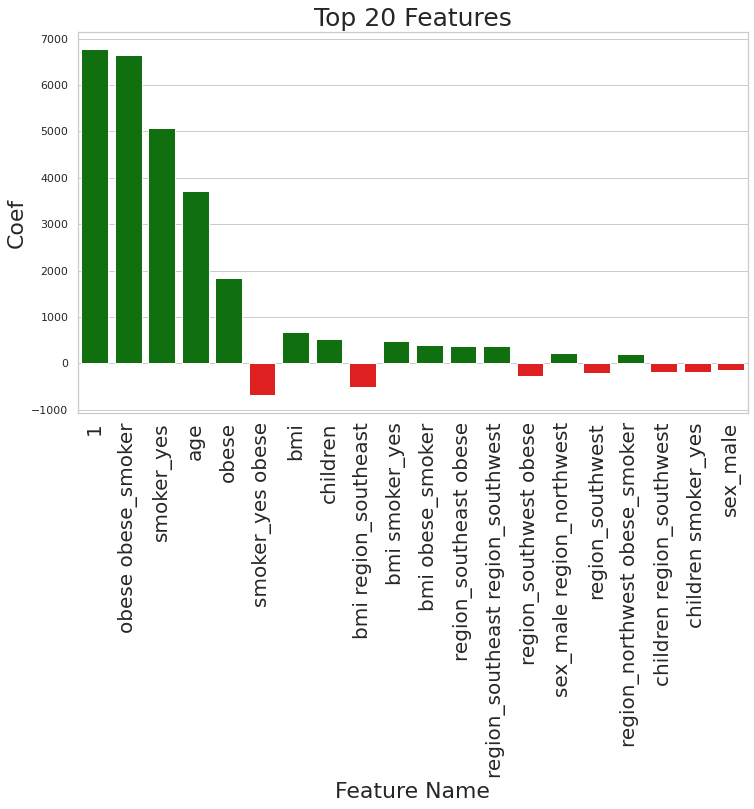

In [97]:
feature_names=xgb_model.named_steps['polynomialfeatures'].get_feature_names_out(X_train.columns)
coefs = xgb_model.named_steps["xgbregressor"].coef_.flatten()
# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)
print(len(feature_names))
print(len(coefs))

56
56


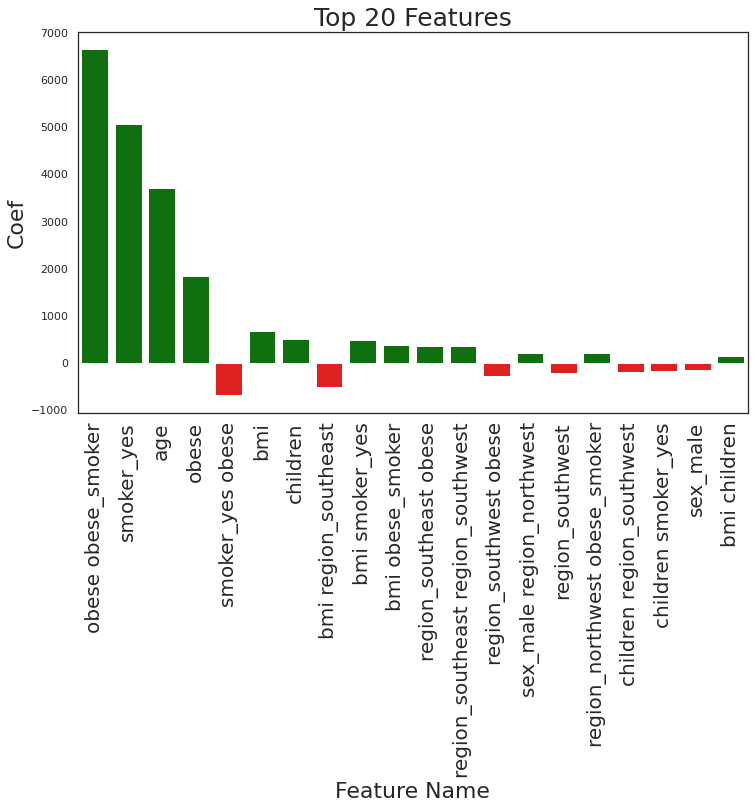

In [135]:
sns.set_style('white')
feature_names=xgb_model.named_steps['polynomialfeatures'].get_feature_names_out(X_train.columns)
coefs = xgb_model.named_steps["xgbregressor"].coef_.flatten()
# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.iloc[1:21],
           palette=df.iloc[1:21]["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)
print(len(feature_names))
print(len(coefs))

<center> <h1> Charakterystyka grup klientów w zależości od poziomu opłat. <h1> <center>

In [136]:
# dodanie progow oplat
df['charges_thresholds'] = 0

# progi:
IV_opis = '> 30.000'
III_opis = '15.000 - 30.000'
III_prog = 30000
II_prog = 15000
II_opis = '6.000 - 15.000'
I_prog = 6000
I_opis = '< 6.000'

for index, row in df.iterrows():
    if row['charges'] > III_prog:
        df.loc[index,'charges_thresholds'] = IV_opis
    elif row['charges'] < I_prog:
        df.loc[index,'charges_thresholds'] = I_opis
    elif row['charges'] > I_prog and row['charges'] < II_prog:
        df.loc[index,'charges_thresholds'] = II_opis
    else:
        df.loc[index,'charges_thresholds'] = III_opis
        
# df.groupby('charges_thresholds').mean()

KeyError: 'charges'

In [110]:
group_1 = df[df['charges'] < I_prog]
group_2 = df[df['charges'] < II_prog]
group_3 = df[df['charges'] <= III_prog]
group_4 = df[df['charges'] > III_prog]

KeyError: 'charges'

In [111]:
df

,feature,value,abs_value,colors,charges_thresholds
0,1,"6,766.44","6,766.44",green,0
55,obese obese_smoker,"6,654.94","6,654.94",green,0
5,smoker_yes,"5,068.77","5,068.77",green,0
1,age,"3,705.23","3,705.23",green,0
9,obese,"1,846.25","1,846.25",green,0
44,smoker_yes obese,-692.42,692.42,red,0
2,bmi,673.38,673.38,green,0
3,children,512.89,512.89,green,0
24,bmi region_southeast,-510.86,510.86,red,0
22,bmi smoker_yes,481.20,481.20,green,0


In [112]:
df_mean = df.groupby('charges_thresholds').mean()
df_mean

,value,abs_value
charges_thresholds,,
0,457.05,543.60


In [ ]:
df_std = df.groupby('charges_thresholds').std()
df_std

In [ ]:
tick_values = df_mean.index
tick_order = '< 6.000', '6.000 - 15.000', '15.000 - 30.000', '> 30.000'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Mean age by charges thresholds')
ax1 = sns.barplot(y=df_mean['age'], 
                     x=tick_values, 
                     yerr=df_std['age'], 
                     order=tick_order, ax=ax1)
ax1.set_xlabel('Charges thresholds')
ax1.set_ylabel('Mean age')

ax2 = sns.boxplot(data=df, y='age', x='charges_thresholds', order=tick_order, ax=ax2)
ax2.set_xlabel('Charges thresholds')
ax2.set_ylabel('Mean age')

plt.show()

In [ ]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Mean bmi by charges thresholds')
ax3 = sns.barplot(y=df_mean['bmi'], 
                     x=tick_values, 
                     yerr=df_std['bmi'], 
                     order=tick_order, ax=ax3)
ax3.set_xlabel('Charges thresholds')
ax3.set_ylabel('Mean bmi')

ax4 = sns.boxplot(data=df, y='bmi', x='charges_thresholds', order=tick_order, ax=ax4)
ax4.set_xlabel('Charges thresholds')
ax4.set_ylabel('Mean bmi')

plt.show()

In [ ]:
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('No of children by charges thresholds')
ax5 = sns.barplot(y=df_mean['children'], 
                     x=tick_values, 
                     yerr=df_std['children'], 
                     order=tick_order, ax=ax5)
ax5.set_xlabel('Charges thresholds')
ax5.set_ylabel('Mean children No')

ax6 = sns.boxplot(data=df, y='children', x='charges_thresholds', order=tick_order, ax=ax6)
ax6.set_xlabel('Charges thresholds')
ax6.set_ylabel('Mean children No')

plt.show()

In [ ]:
fig, (ax7, ax8) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Mean charges by charges thresholds')
ax7 = sns.barplot(y=df_mean['charges'], 
                     x=tick_values, 
                     yerr=df_std['charges'], 
                     order=tick_order, ax=ax7)
ax7.set_xlabel('Charges thresholds')
ax7.set_ylabel('Mean charges')

ax8 = sns.boxplot(data=df, y='charges', x='charges_thresholds', order=tick_order, ax=ax8)
ax8.set_xlabel('Charges thresholds')
ax8.set_ylabel('Mean charges')

plt.show()

In [ ]:
# dodanie progow oplat
initial_df['charges_thresholds'] = 0

# progi:
IV_opis = '> 30.000'
III_opis = '15.000 - 30.000'
III_prog = 30000
II_prog = 15000
II_opis = '6.000 - 15.000'
I_prog = 6000
I_opis = '< 6.000'

for index, row in initial_df.iterrows():
    if row['charges'] > III_prog:
        initial_df.loc[index,'charges_thresholds'] = IV_opis
    elif row['charges'] < I_prog:
        initial_df.loc[index,'charges_thresholds'] = I_opis
    elif row['charges'] > I_prog and row['charges'] < II_prog:
        initial_df.loc[index,'charges_thresholds'] = II_opis
    else:
        initial_df.loc[index,'charges_thresholds'] = III_opis

In [ ]:
initial_df

In [ ]:
fig, (ax9, ax10) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax9 = sns.countplot(data=initial_df, x=initial_df['charges_thresholds'], hue=initial_df['smoker'], 
                     order=tick_order, ax=ax9)
ax9.set_title('No of smokers / non_smokers by charges thresholds')
ax9.set_xlabel('Charges thresholds')

ax10 = sns.countplot(data=initial_df, x=initial_df['charges_thresholds'], hue=initial_df['region'], 
                   order=tick_order, ax=ax10)
ax10.set_title('Region by charges thresholds')
ax10.set_xlabel('Charges thresholds')

plt.show()

describe dla group

# Group 1

In [99]:
desc_1 = group_1.describe(percentiles=[.1, .25, .5, .75, .9]).T
desc_1

,count,mean,std,min,10%,25%,50%,75%,90%,max
age,429.00,26.05,6.33,18.00,18.00,20.00,25.00,31.00,35.00,42.00
bmi,429.00,30.04,6.22,15.96,22.21,25.80,29.92,34.10,38.43,53.13
children,429.00,0.81,1.08,0.00,0.00,0.00,0.00,1.00,2.00,5.00
charges,429.00,"3,393.00","1,390.28","1,121.87","1,645.06","2,138.07","3,279.87","4,564.19","5,357.93","5,989.52"
sex_male,429.00,0.50,0.50,0.00,0.00,0.00,1.00,1.00,1.00,1.00
smoker_yes,429.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
region_northwest,429.00,0.25,0.43,0.00,0.00,0.00,0.00,0.00,1.00,1.00
region_southeast,429.00,0.29,0.46,0.00,0.00,0.00,0.00,1.00,1.00,1.00
region_southwest,429.00,0.25,0.43,0.00,0.00,0.00,0.00,1.00,1.00,1.00
obese,429.00,0.49,0.50,0.00,0.00,0.00,0.00,1.00,1.00,1.00


# Group 2

In [100]:
desc_2 = group_2.describe(percentiles=[.1, .25, .5, .75, .9]).T
desc_2

,count,mean,std,min,10%,25%,50%,75%,90%,max
age,980.00,38.85,13.98,18.00,19.00,26.00,39.00,51.00,58.00,64.00
bmi,980.00,30.49,6.15,15.96,22.61,26.10,30.20,34.32,38.68,53.13
children,980.00,1.06,1.21,0.00,0.00,0.00,1.00,2.00,3.00,5.00
charges,980.00,"7,112.21","3,869.93","1,121.87","2,097.57","3,701.62","6,789.11","10,411.04","12,629.24","14,988.43"
sex_male,980.00,0.49,0.50,0.00,0.00,0.00,0.00,1.00,1.00,1.00
smoker_yes,980.00,0.01,0.08,0.00,0.00,0.00,0.00,0.00,0.00,1.00
region_northwest,980.00,0.25,0.43,0.00,0.00,0.00,0.00,0.00,1.00,1.00
region_southeast,980.00,0.25,0.43,0.00,0.00,0.00,0.00,1.00,1.00,1.00
region_southwest,980.00,0.26,0.44,0.00,0.00,0.00,0.00,1.00,1.00,1.00
obese,980.00,0.52,0.50,0.00,0.00,0.00,1.00,1.00,1.00,1.00


# Group 3

In [101]:
desc_3 = group_3.describe(percentiles=[.1, .25, .5, .75, .9]).T
desc_3

,count,mean,std,min,10%,25%,50%,75%,90%,max
age,"1,176.00",39.05,13.99,18.00,19.00,26.00,39.00,51.00,58.00,64.00
bmi,"1,176.00",30.09,6.04,15.96,22.61,25.79,29.70,33.89,38.18,53.13
children,"1,176.00",1.09,1.21,0.00,0.00,0.00,1.00,2.00,3.00,5.00
charges,"1,176.00","9,483.41","6,565.95","1,121.87","2,203.60","4,348.85","8,246.44","12,629.35","19,567.03","29,523.17"
sex_male,"1,176.00",0.49,0.50,0.00,0.00,0.00,0.00,1.00,1.00,1.00
smoker_yes,"1,176.00",0.10,0.31,0.00,0.00,0.00,0.00,0.00,1.00,1.00
region_northwest,"1,176.00",0.25,0.43,0.00,0.00,0.00,0.00,1.00,1.00,1.00
region_southeast,"1,176.00",0.26,0.44,0.00,0.00,0.00,0.00,1.00,1.00,1.00
region_southwest,"1,176.00",0.24,0.43,0.00,0.00,0.00,0.00,0.00,1.00,1.00
obese,"1,176.00",0.47,0.50,0.00,0.00,0.00,0.00,1.00,1.00,1.00


# Group 4

In [102]:
desc_4 = group_4.describe(percentiles=[.1, .25, .5, .75, .9]).T
desc_4

,count,mean,std,min,10%,25%,50%,75%,90%,max
age,162.00,40.38,14.47,18.00,20.00,27.00,42.00,52.75,60.00,64.00
bmi,162.00,34.85,4.74,17.77,30.21,31.69,34.65,37.03,40.88,52.58
children,162.00,1.17,1.14,0.00,0.00,0.00,1.00,2.00,3.00,4.00
charges,162.00,"40,761.31","6,165.96","30,063.58","33,901.34","36,203.13","39,854.11","44,482.00","47,924.91","63,770.43"
sex_male,162.00,0.64,0.48,0.00,0.00,0.00,1.00,1.00,1.00,1.00
smoker_yes,162.00,0.94,0.24,0.00,1.00,1.00,1.00,1.00,1.00,1.00
region_northwest,162.00,0.18,0.38,0.00,0.00,0.00,0.00,0.00,1.00,1.00
region_southeast,162.00,0.38,0.49,0.00,0.00,0.00,0.00,1.00,1.00,1.00
region_southwest,162.00,0.23,0.42,0.00,0.00,0.00,0.00,0.00,1.00,1.00
obese,162.00,0.92,0.27,0.00,1.00,1.00,1.00,1.00,1.00,1.00
